In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import datetime
from scipy import stats
from scipy.stats import poisson, ttest_ind
sns.set_palette('colorblind')

In [3]:
biden = pd.read_csv("biden_tweets.csv")
trump = pd.read_csv("trump_tweets.csv")
# want to do cluster analysis, based on created_at date and favourites / retweets recieved 
# cluster by morning / day / evening <- created_at represented with military time 

In [4]:
biden.head()
biden.dtypes
date = biden["created_at"]
date[0]
biden["date"] = pd.to_datetime(biden["created_at"], format = "%Y-%m-%d %H:%M:%S")
trump["date"] = pd.to_datetime(trump["created_at"], format = "%Y-%m-%d %H:%M:%S")

len(trump['date'])

1607

In [7]:
# assign time of day values 
# morning = 5 am : 12 pm = any hour value from 5 to 11 
# afternoon = 12 pm : 5 pm = any hour value from 12 to 16 
# evening = 5 pm : 10 pm = any hour value from 17 to 22 
# night = 10 pm : 5 am = any hour value from 23 to 4 (23,0,1,2,3,4) <- wrap around
time_of_day_b = [None] * len(biden['date'])
for i in range(len(biden["date"])):
    hour = biden["date"][i].hour 
    if  5 <= hour <= 11: 
        time_of_day_b[i] = "morning"
    elif 12 <= hour <= 16:
        time_of_day_b[i] = "afternoon"
    elif 17 <= hour <= 22:
        time_of_day_b[i] = "evening"
    else:
        time_of_day_b[i] = "night"
# create column for word count 
tweet_length_b = [None] * len(biden['date'])
for i in range(len(biden["full_text"])):
    tweet_length_b[i] = len(biden["full_text"][i].split())

# same data processing for trump 
time_of_day_t = [None] * len(trump['date'])
for i in range(len(trump["date"])):
    hour = trump["date"][i].hour 
    if  5 <= hour <= 11: 
        time_of_day_t[i] = "morning"
    elif 12 <= hour <= 16:
        time_of_day_t[i] = "afternoon"
    elif 17 <= hour <= 22:
        time_of_day_t[i] = "evening"
    else:
        time_of_day_t[i] = "night"
# create column for word count 
tweet_length_t = [None] * len(trump['date'])
for i in range(len(trump["full_text"])):
    tweet_length_t[i] = len(trump["full_text"][i].split())
    


hour_b = [None] * len(biden['date'])
for i in range(len(biden['date'])):
    hour_b[i] = biden['date'][i].hour
             
hour_t = [None] * len(trump['date'])
for i in range(len(trump['date'])):
    hour_t[i] = trump['date'][i].hour

biden['time_of_day'] = time_of_day_b
biden['tweet_length'] = tweet_length_b
trump['time_of_day'] = time_of_day_t
trump['tweet_length'] = tweet_length_t
biden['hour'] = hour_b 
trump['hour'] = hour_t

# create columns that contain series of night vs day where night = 1 , day = 0 
day_night_map = {"morning":0, "afternoon":0, "evening":1, "night":1}
biden['day_or_night'] = biden['time_of_day'].map(day_night_map)
trump['day_or_night'] = trump['time_of_day'].map(day_night_map)
    

In [8]:
biden.head()

,Unnamed: 0,id,full_text,entities,created_at,favourite,retweets,language,geo,in_reply,date,time_of_day,tweet_length,hour,day_or_night
0,0,1313663334286323714,Please. https://t.co/acHR1Rf8hE,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-07 02:12:00,90289,14867,en,NaN,NaN,2020-10-07 02:12:00,night,2,2,1
1,1,1313652765319557122,I can’t wait for @KamalaHarris to make history...,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-07 01:30:00,13317,2126,en,NaN,NaN,2020-10-07 01:30:00,night,30,1,1
2,2,1313646473393840128,"Ignore the polls, folks. There’s too much at s...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-07 01:05:00,56278,12104,en,NaN,NaN,2020-10-07 01:05:00,night,28,1,1
3,3,1313641691602202624,Think about what it takes for a Black person t...,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-07 00:46:00,30592,6574,en,NaN,NaN,2020-10-07 00:46:00,night,30,0,1
4,4,1313633890289045504,"Look, folks, I'm going to be honest: we'll try...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-07 00:15:00,13490,3023,en,NaN,NaN,2020-10-07 00:15:00,night,43,0,1


In [9]:
trump.head()

,Unnamed: 0,id,full_text,entities,created_at,favourite,retweets,language,geo,in_reply,date,time_of_day,tweet_length,hour,day_or_night
0,0,1314035056441257985,https://t.co/wHQx2qd8q2,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-08 02:49:05,7856,2700,und,NaN,NaN,2020-10-08 02:49:05,night,1,2,1
1,1,1314033009293656065,"2010 to 2016 under Kamala Harris's watch as ""T...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-08 02:40:57,22294,8828,en,NaN,NaN,2020-10-08 02:40:57,night,12,2,1
2,2,1314028978806624256,https://t.co/4Wv5cCFEns https://t.co/kMvBv6Pu9I,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-08 02:24:56,18191,5547,und,NaN,NaN,2020-10-08 02:24:56,night,2,2,1
3,3,1314028699084259329,https://t.co/rxqPqR4uqZ,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-08 02:23:49,37800,9667,und,NaN,NaN,2020-10-08 02:23:49,night,1,2,1
4,4,1314027975185182721,https://t.co/xGevgI2wTO,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-10-08 02:20:57,24724,7687,und,NaN,NaN,2020-10-08 02:20:57,night,1,2,1


In [10]:
# show number of tweets at certain times. I found it suprising the large amount of tweets during the night 
print("Biden: ")
print(biden.time_of_day.value_counts()) 
print('\n')
print("Trump: ")
print(trump.time_of_day.value_counts())


Biden: 
evening      1343
night        1196
afternoon     518
morning        27
Name: time_of_day, dtype: int64


Trump: 
night        555
evening      476
afternoon    409
morning      167
Name: time_of_day, dtype: int64


In [ ]:
# x axis constrained from 0 to 600,000 to remove outliers (tweets that recieved an abnormal amount of likes). 
# Time of day does not seem to impact favorite and retweet counts. 
# Linear relationship between number of favorites and number
# of retweets is expected. A more liked tweet is also expected to be have more retweets.

# sns.relplot(x = "favourite", y = "retweets", hue = "time_of_day", alpha = 0.4, data = biden)
# plt.xlabel("Number of Favorites")
# plt.ylabel("Number of Retweets")
# plt.xlim(left = 0, right = 600000)
# plt.ylim(bottom = 0, top = 300000)
# plt.show()

# sns.relplot(x = "favourite", y = "retweets", hue = "time_of_day", alpha = 0.4, data = trump)
# plt.xlabel("Number of Favorites")
# plt.ylabel("Number of Retweets")
# plt.xlim(left = 0, right = 600000)
# plt.ylim(bottom = 0, top = 300000)
# plt.show()


no clusters found when doing favorites vs retweets, which is why it is commented out 

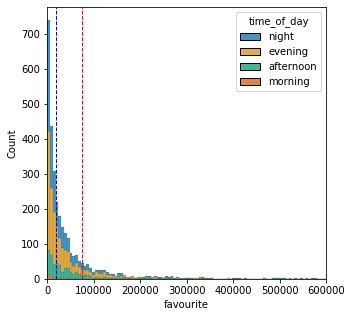

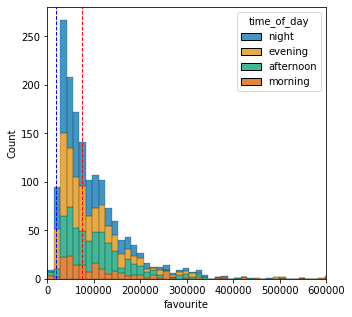

In [11]:
# blue dashed line = biden median value for favorites recieved 
# red dashed line = trump median value for favorites recieved 
plt.figure(figsize = (5,5))
sns.histplot(x="favourite", hue="time_of_day", multiple = "stack", data = biden)
plt.xlim(left = 0, right = 600000)
plt.axvline(biden['favourite'].median(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(trump['favourite'].median(), color='red', linestyle='dashed', linewidth=1)

plt.figure(figsize = (5,5))
sns.histplot(x="favourite", hue="time_of_day", multiple = "stack", data = trump)
plt.xlim(left = 0, right = 600000)
plt.axvline(biden['favourite'].median(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(trump['favourite'].median(), color='red', linestyle='dashed', linewidth=1)


plt.show()

### Tweet Length vs Number of Favorites

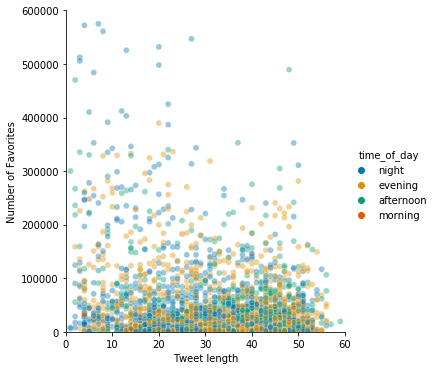

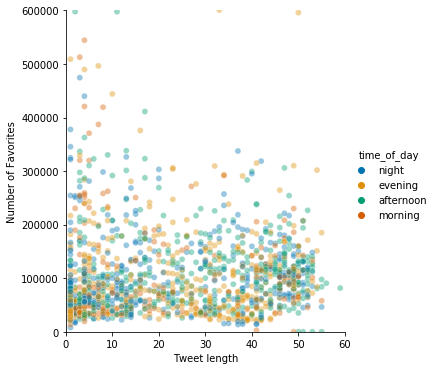

In [12]:
# does not seem to be a relationship between tweet length and number of favorites recieved 
# trump has many tweets that are a single hyperlink to another tweet, which is why he has many tweets of length = 1

sns.relplot(x = "tweet_length", y = "favourite", hue = "time_of_day", alpha = 0.4, data = biden)
plt.xlabel("Tweet length")
plt.ylabel("Number of Favorites")
plt.xlim(left = 0, right = 60)
plt.ylim(bottom = 0, top = 600000)

sns.relplot(x = "tweet_length", y = "favourite", hue = "time_of_day", alpha = 0.4, data = trump)
plt.xlabel("Tweet length")
plt.ylabel("Number of Favorites")
plt.xlim(left = 0, right = 60)
plt.ylim(bottom = 0, top = 600000)
plt.show()

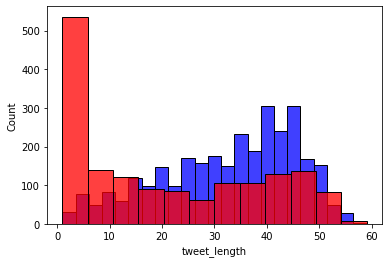

In [13]:
sns.histplot(x="tweet_length", color = 'blue', data = biden)
sns.histplot(x="tweet_length", color = 'red',data = trump)
plt.show()

### Research Question: Does time of day impact tweet behavior? 
#### null hypothesis : time of day does not impact amount of favorites recieved by a tweet <- check for both trump and biden

In [15]:
# create columns that contain series of favorites depending on time of day
print("Biden:")
print(ttest_ind(biden['favourite'], biden['day_or_night']))
print("\n" + "Trump:")
print(ttest_ind(trump['favourite'], trump['tweet_length']))

Biden:
Ttest_indResult(statistic=28.5186800786555, pvalue=3.7943280941026356e-168)

Trump:
Ttest_indResult(statistic=40.81308857858013, pvalue=9.738192312218867e-294)


In [16]:
# normalize tweet favourite column 
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit_transform(biden)
# print(ttest_ind(biden['favourite'], biden['hour']))

Both t-tests indicate that the null hypothesis should be suggested, and that there is a significant difference in 
the amount of likes recieved during the day (morning and afternoon) versus during the night (evening and night).

Ttest_indResult(statistic=28.511021489677074, pvalue=4.602892091368418e-168)
Ttest_indResult(statistic=40.81662344097929, pvalue=8.855117197632497e-294)


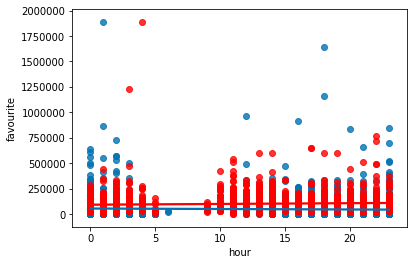

In [23]:
# I don't understand why this p-value is so low, should look into this
print(ttest_ind(biden['favourite'], biden['hour']))
print(ttest_ind(trump['favourite'], trump['hour']))
sns.regplot(x='hour', y = 'favourite', data = biden)
sns.regplot(x='hour', y = 'favourite', color = 'red', data = trump)
plt.show()

In [24]:
print(ttest_ind(trump['favourite'], trump['day_or_night']))

Ttest_indResult(statistic=40.82120501011226, pvalue=7.82859815658317e-294)


slope ~ 0 from looking at graph, which suggests no relation